# Lockdown is almost finished ...

****

### Library and Web Service credentials

In [1]:
#import library
import pandas as pd #Dataframe manipulation
import numpy as np

import requests #for handle http request

!pip install -U geopy #install geopy
import geopy #for geocoding offline
!pip install -U geocoder
import geocoder

import json 

!pip install -U folium
import folium #for mapping plotting
from folium import plugins

import sys #system library

!pip install unidecode
import unidecode # To deal with accent in name of the city

#Vizualization library
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


mpl.style.use('ggplot') # optional: for ggplot-like style

import seaborn as sns

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

#For modelisation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

     |████████████████████████████████| 122kB 6.8MB/s eta 0:00:01
     |████████████████████████████████| 102kB 4.9MB/s ta 0:00:011
     |████████████████████████████████| 92kB 18.4MB/s eta 0:00:01
     |████████████████████████████████| 829kB 22.4MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
     |████████████████████████████████| 102kB 4.8MB/s ta 0:00:011
  Found existing installation: folium 0.5.0
    Uninstalling folium-0.5.0:
      Successfully uninstalled folium-0.5.0
     |████████████████████████████████| 245kB 6.2MB/s eta 0:00:01
Matplotlib version:  3.1.1


In [2]:
#options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#Credentials
with open('credentials.json') as creds:    
    credentials = json.load(creds)
    #key for mapquest
    api_key=credentials['api_key']

    #username for geonames
    geonames_username=credentials['geonames_username']

    #Foursquare credentials
    CLIENT_ID =credentials['CLIENT_ID']# your Foursquare ID
    CLIENT_SECRET =credentials['CLIENT_SECRET'] # your Foursquare Secret
    VERSION =credentials['VERSION']

******

# Step 1 : Data collection

## 1.1 - Set a location of interest

In [4]:
#set a first location
location="Bons-en-Chablais"
location

'Bons-en-Chablais'

We retrieve the geo coordinate of our location of interest

In [5]:
g = geocoder.mapquest(location,key=api_key)
print(g.latlng)
latitude=g.latlng[0]
longitude=g.latlng[1]

[46.264918, 6.370282]


In [6]:
mapping = folium.Map(location=[latitude, longitude], zoom_start=8 , tiles='Stamen Toner')

# add markers to map
folium.Circle(
    [latitude, longitude],
    radius=100000,
    popup="Maximum authorized perimeter (100km)",
    tooltip=" ",
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.5,).add_to(mapping)  
label = folium.Popup(location, parse_html=True)
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup=label,
    color='black',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(mapping)  



    
mapping

## 1.2 - Retrieve the Nearby location

We use the geonames REST API to retrieve all cities in the 100 km nearby our location.

__API documentation__


Find nearby populated place / reverse geocoding
* Webservice Type : REST
* Url : api.geonames.org/findNearbyPlaceName?
* Parameters :
    - lat,lng,
    - lang: language of returned 'name' element (the pseudo language code 'local' will return it in local language),
    - radius: radius in km (optional),
    - maxRows: max number of rows (default 10)
    - style: SHORT,MEDIUM,LONG,FULL (default = MEDIUM),    verbosity of returned xml document
    - localCountry: in border areas this parameter will restrict the search on the local country, value=true
    - cities: optional filter parameter with three possible values 'cities1000', 'cities5000','cities15000'. See the download readme for further infos
    
    
Result : returns the closest populated place (feature class=P) for the lat/lng query as xml document. The unit of the distance element is 'km'.


Example:
JSON format
http://api.geonames.org/findNearbyPlaceNameJSON?lat=47.3&lng=9&username=demo

In [7]:
#Set parameters 
username=geonames_username
lat=latitude
lng=longitude
radius=100
maxRows=500
style='MEDIUM'
localCountry=True
cities='cities1000'

#create the URL for the API
url='http://api.geonames.org/findNearbyPlaceNameJSON?lat={}&lng={}&radius={}&maxRows={}&style={}&localCountry={}&cities={}&username={}'.format(lat,lng,radius,maxRows,style,localCountry,cities,username)
url

'http://api.geonames.org/findNearbyPlaceNameJSON?lat=46.264918&lng=6.370282&radius=100&maxRows=500&style=MEDIUM&localCountry=True&cities=cities1000&username=william.mnr'

In [8]:
#Get the result
results = requests.get(url).json()

In [9]:
#Transform the result in dataframe
df = pd.json_normalize(results['geonames'])
print(df.shape)

#Convert dataframe fields type 
df[['lng','distance','lat']]=df[['lng','distance','lat']].astype(float)

#remove our location from the dataframe (we won't go in vacation into our city ...)
df=df[df['name']!=location]
df['name_std'] = df['name'].apply(unidecode.unidecode)
#Remove unwanted fields
unwanted_column=['adminCode1','geonameId','toponymName','countryId','fcl','countryCode','fclName','fcodeName','adminName1','fcode','adminCodes1.ISO3166_2']
df.drop(unwanted_column,axis=1,inplace=True)
df.tail()

(353, 17)


,lng,distance,population,name,countryName,lat,name_std
348,6.27315,98.80900,1030,Étalans,France,47.15125,Etalans
349,5.19920,98.86992,7467,Meximieux,France,45.90823,Meximieux
350,6.07519,99.42645,3783,Allevard,France,45.39449,Allevard
351,5.41110,99.49965,1263,Sermérieu,France,45.66995,Sermerieu
352,5.52136,99.75772,1195,Faverges-de-la-Tour,France,45.59068,Faverges-de-la-Tour


In [10]:

mapping = folium.Map(location=[latitude, longitude], zoom_start=8.2 , tiles='Stamen Toner')
folium.Circle(
    [latitude, longitude],
    radius=100000,
    popup="Maximum authorized perimeter (100km)",
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.5,).add_to(mapping)  

label = folium.Popup(location, parse_html=True)
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup=label,
    color='black',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(mapping)  

for lat, lng, city, pop in zip(df['lat'], df['lng'], df['name_std'], df['population']):
    
    label = "{}, pop: {}".format(city,pop)
    
    label = folium.Popup(label) #, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapping)  
    
mapping
   

## 1.3 : Retrieve all venues in each cities previously found

Retrieve venus for each location

We use the Foursquare REST API to retrieve into each cities of our dataframe the venues available.

__API Documentation:__
    
* Parameters
    - ll: latitude,longitude fo the city
    - radius : the radius around the city to bound the research (in meters)
    - near: to retrieve only venues in the city of the location
    - LIMIT: set the limit number for the result (maximum=200)
    - type : explore

We define a function to iter on each cities

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius,LIMIT):
    global error_list
    
    error_list=[]
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&near={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            name,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        code=results['meta']['code']
        
        if code==429:
            print('No dataset created : Quota exceeded')
            break 
            
    # return only relevant information for each nearby venue
        try:
            results=results["response"]['groups'][0]['items']
            venues_list.append([(
                    name, 
                    lat, 
                    lng,
                    v['venue']['id'],
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])
        except KeyError:
            print('ERROR: ------------------->',name)
            error_list.append(name)
            
        


            
        
    if code==429:
        return('No dataset created : Quota exceeded')
        sys.exit(0)
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Save result to reuse after

******

# Step 2 : Cleaning Data and Explore

Reimport result

In [12]:
#Nearby_venues=pd.read_csv('save_fromfoursquare_v20180605.csv')
Nearby_venues=pd.read_csv('save_fromfoursquare.csv')
Nearby_venues.rename(columns={'Unnamed: 0': 'index_n'},inplace=True)

## 2.1 : Remove unwanted location

Explore the category type

In [13]:
unique = pd.DataFrame(Nearby_venues['Venue Category'].sort_values().unique())
print(len(unique))

266


There is 266 unique Category. This is too much. We remove some Venue Categories which are not usefull for plan vacation, like Border or Toll booth.

In [14]:
#Clean unwanted location like Train Station, Border Corssing, Rest Area ...'Auto Dealership':'---> REMOVE',
unwanted_venue=['Border Crossing', 'Toll Booth', 'Tunnel', 'Trade School', 'Multiplex','Rest Area', 'Factory','Construction & Landscaping','Auto Dealership','Neighborhood','Toll Plaza']

Nearby_venues = Nearby_venues[Nearby_venues['Venue Category'].isin(unwanted_venue) == False]
Nearby_venues.tail()


,index_n,City,City Latitude,City Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
3671,3671,Sermérieu,45.66995,5.41110,5e0d0f5c6492ab0008839f4c,GT Elec 38,45.675325,5.418213,Furniture / Home Store
3672,3672,Faverges-de-la-Tour,45.59068,5.52136,4cae9dcc1463a1434d558ea9,CF,45.590320,5.535833,Hotel
3673,3673,Faverges-de-la-Tour,45.59068,5.52136,5e2090d5a292720008da0cc5,Collonge,45.595437,5.521126,Home Service
3674,3674,Faverges-de-la-Tour,45.59068,5.52136,5a14350012c8f063454b6084,Pharmacie de la soie,45.581030,5.528660,Pharmacy
3675,3675,Faverges-de-la-Tour,45.59068,5.52136,56897cfa498e809a77ec6935,anim'heureux,45.585513,5.541122,Pet Store


***

## 2.2 : Standardization of Venue Category

To standardize our data, we use the scheme techniques which consist to change label of category data. 
For example, we label 'French Restaurant' and 'Italian Restaurant' as  'Restaurant'


We have 262 distinct category of venues and standardize in 12 category. 

We create a spceific dataframe. We will join it later with our primary dataframe.

In [15]:

df_scheme=pd.DataFrame({'Venue Category':pd.Series(Nearby_venues['Venue Category']).tolist(),'Venue Category std':pd.Series(Nearby_venues['Venue Category']).tolist(),'index_n':Nearby_venues['index_n']})
df_scheme.set_index('index_n',inplace=True)

df_scheme.head()

,Venue Category,Venue Category std
index_n,,
0,Hotel,Hotel
2,Brewery,Brewery
3,Historic Site,Historic Site
4,French Restaurant,French Restaurant
5,Deli / Bodega,Deli / Bodega


In [16]:
def load_scheme(file):
    import csv # To import scheme
    scheme={}
    with open(file, newline='') as file_:
        reader=csv.reader(file_, delimiter=':')
        i=0
        for row in reader:
            #print(i,':',row) # to debug if necessary
            scheme[row[0]]=row[1]
            i=i+1
        return scheme

In [17]:
def apply_scheme(dataset,std_variable,schema_dict):
    for key, value in schema_dict.items():
        dataset[std_variable] = dataset[std_variable].replace(key, value)

In [18]:
scheme = load_scheme(file='scheme_standardization_v3.txt')
apply_scheme(dataset=df_scheme,std_variable='Venue Category std',schema_dict=scheme)

In [19]:
print('Number of category Before standardization: ', len(df_scheme['Venue Category'].sort_values().unique()))
print('Number of category After standardization: ', len(df_scheme['Venue Category std'].sort_values().unique()))

Number of category Before standardization:  255
Number of category After standardization:  14


In [20]:
df_scheme.groupby('Venue Category std').count().sort_values('Venue Category')


,Venue Category
Venue Category std,
Asian Restaurant,31
Cultural activities,36
Fast Food,86
Indoor activities,93
Outdoors activities,189
Sport activities,196
Tourism activities,201
Bar/Coffee,294
Commodities,325


We made a simple hypothesis, the venue Category 'Commodities' is not very usefull to plan vacation, as we can see below. So we remove them.

In [21]:
list(df_scheme[df_scheme['Venue Category std']=='Commodities']['Venue Category'].unique())

['Pharmacy',
 'Entertainment Service',
 'Home Service',
 'Train Station',
 'Gas Station',
 'Bus Station',
 'Auto Workshop',
 'Assisted Living',
 'Business Service',
 'General Travel',
 'Tourist Information Center',
 'Daycare',
 'Fire Station',
 'Rental Service',
 'Rental Car Location',
 'Recycling Facility',
 'Auto Garage',
 'Bank',
 'Bike Rental / Bike Share',
 'Health & Beauty Service',
 'Financial or Legal Service',
 'Funeral Home',
 'Lawyer',
 'Astrologer',
 'Insurance Office',
 'Airport',
 'Travel & Transport',
 'Airport Service',
 'Real Estate Office',
 'Stables',
 'IT Services',
 'Event Service',
 'Pet Service',
 'Alternative Healer']

In [22]:
df_scheme=df_scheme[df_scheme['Venue Category std'] != 'Commodities']

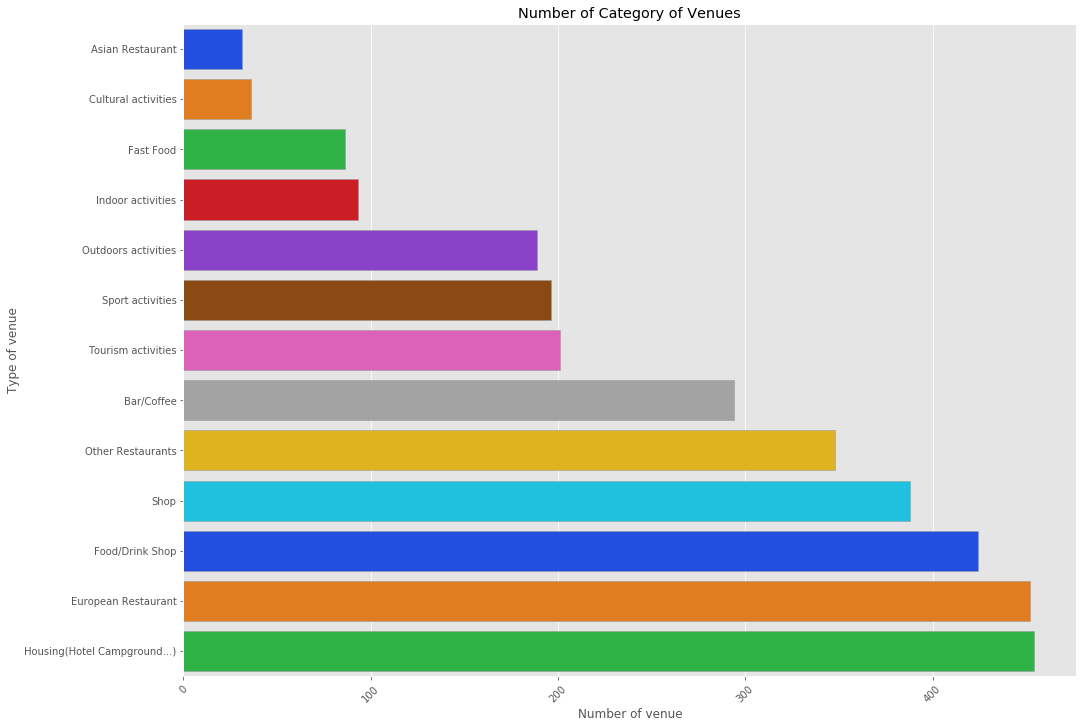

In [23]:
graph_count=df_scheme.groupby('Venue Category std').count().sort_values('Venue Category').reset_index()

plt.figure(figsize=(16,12))
sns.barplot(x="Venue Category", y='Venue Category std',orient='h',
            palette="bright", edgecolor=".6",
            data=graph_count);

plt.title('Number of Category of Venues') # add a title to the histogram
plt.ylabel('Type of venue') # add y-label
plt.xlabel('Number of venue') # add x-label
plt.xticks(rotation=45)

plt.show()

In [24]:
df_scheme.head()

,Venue Category,Venue Category std
index_n,,
0,Hotel,Housing(Hotel Campground...)
2,Brewery,Bar/Coffee
3,Historic Site,Tourism activities
4,French Restaurant,European Restaurant
5,Deli / Bodega,Other Restaurants


We reinject our standardize Venue Category in our dataset

In [25]:
df_scheme.drop('Venue Category',axis=1,inplace=True)
Nearby_venues.set_index('index_n',inplace=True)

Nearby_venues2 = Nearby_venues.join(df_scheme)


In [26]:
Nearby_venues2.dropna(axis=0,how='any',subset=['Venue Category std'],inplace=True)
Nearby_venues2.info()
Nearby_venues2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3192 entries, 0 to 3675
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                3192 non-null   object 
 1   City Latitude       3192 non-null   float64
 2   City Longitude      3192 non-null   float64
 3   Venue Id            3192 non-null   object 
 4   Venue               3192 non-null   object 
 5   Venue Latitude      3192 non-null   float64
 6   Venue Longitude     3192 non-null   float64
 7   Venue Category      3192 non-null   object 
 8   Venue Category std  3192 non-null   object 
dtypes: float64(4), object(5)
memory usage: 249.4+ KB


,City,City Latitude,City Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category std
index_n,,,,,,,,,
0,Ballaison,46.29842,6.32765,4e06e68718a8382643b11f30,À L'ombre Des Kiwis,46.296338,6.354576,Hotel,Housing(Hotel Campground...)
2,Ballaison,46.29842,6.32765,5082422ac84c22998a61c53f,La Tombee,46.299190,6.328543,Brewery,Bar/Coffee
3,Ballaison,46.29842,6.32765,4ff2921fe4b0365ccbf28e28,Chateau De Thénières,46.303017,6.325524,Historic Site,Tourism activities
4,Ballaison,46.29842,6.32765,4eebc699be7b6d62fe8e9114,Ô Flaveurs,46.301800,6.313452,French Restaurant,European Restaurant
5,Ballaison,46.29842,6.32765,4dfcb40ea809d61e2fc0a57f,La Mère Gaud,46.300250,6.327542,Deli / Bodega,Other Restaurants


## 2.3 Number of venues and One Hot encoding

Before Perform the One Hot encoding, we just check that some city have a sufficent number of venue. As the One hot is based on regroup venue of each city and then compute a mean(), if we have only 1 city, this fact cause trouble in data for later.
We do this by a double count.


In [27]:
Onehot = pd.get_dummies(Nearby_venues2[['Venue Category std']], prefix="", prefix_sep="")
Onehot['name'] = Nearby_venues2['City'] 
fixed_columns2 = [Onehot.columns[-1]] + list(Onehot.columns[:-1])
Onehot = Onehot[fixed_columns2]
Onehot.head()

,name,Asian Restaurant,Bar/Coffee,Cultural activities,European Restaurant,Fast Food,Food/Drink Shop,Housing(Hotel Campground...),Indoor activities,Other Restaurants,Outdoors activities,Shop,Sport activities,Tourism activities
index_n,,,,,,,,,,,,,,
0,Ballaison,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Ballaison,0,1,0,0,0,0,0,0,0,0,0,0,0
3,Ballaison,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Ballaison,0,0,0,1,0,0,0,0,0,0,0,0,0
5,Ballaison,0,0,0,0,0,0,0,0,1,0,0,0,0


In [28]:
pre_count = (Onehot.groupby('name').count()).groupby('Bar/Coffee').count().reset_index()
pre_count.rename(columns={'Asian Restaurant':'Count','Bar/Coffee':'Number of venues'}, inplace=True)
pre_count=pre_count[['Number of venues','Count']]
pre_count.set_index('Number of venues', inplace=True)
pre_count.head(5)

,Count
Number of venues,
1,26
2,31
3,49
4,58
5,40


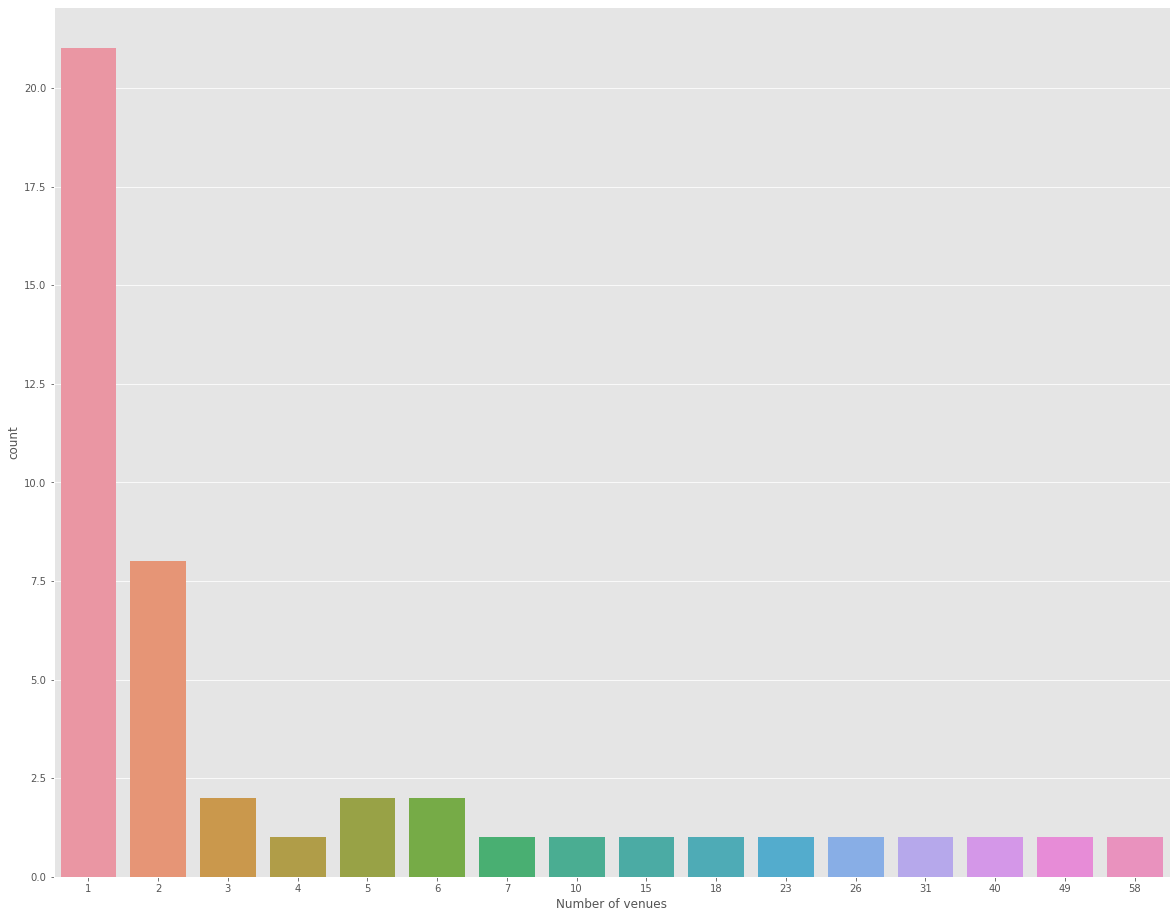

In [29]:
plt.figure(figsize=(20,16))
sns.countplot( x='Count', data=pre_count)
plt.xlabel('Number of venues')
plt.show()

So we remove city with only one venue to improve results.

In [30]:
#Before removing
print(len(Onehot.groupby('name').count().index))

346


In [31]:
tmp = Onehot.groupby('name').count().reset_index()
tmp = tmp[tmp['Bar/Coffee'] <=1]
Nearby_venues3 = Nearby_venues2.set_index('City')
Nearby_venues3.drop(tmp['name'], axis=0, inplace=True)
Nearby_venues3.reset_index(inplace=True)

In [32]:
tmp.head()

,name,Asian Restaurant,Bar/Coffee,Cultural activities,European Restaurant,Fast Food,Food/Drink Shop,Housing(Hotel Campground...),Indoor activities,Other Restaurants,Outdoors activities,Shop,Sport activities,Tourism activities
7,Alby-sur-Chéran,1,1,1,1,1,1,1,1,1,1,1,1,1
12,Ambronay,1,1,1,1,1,1,1,1,1,1,1,1,1
23,Arenthon,1,1,1,1,1,1,1,1,1,1,1,1,1
34,Barraux,1,1,1,1,1,1,1,1,1,1,1,1,1
43,Bletterans,1,1,1,1,1,1,1,1,1,1,1,1,1


In [33]:
Onehot = pd.get_dummies(Nearby_venues3[['Venue Category std']], prefix="", prefix_sep="")
Onehot['name'] = Nearby_venues3['City'] 
fixed_columns2 = [Onehot.columns[-1]] + list(Onehot.columns[:-1])
Onehot = Onehot[fixed_columns2]
Nearby_grouped = Onehot.groupby('name').mean().reset_index()

print('With scheme:' ,Nearby_grouped.shape)
Nearby_grouped.head(5)
df2= df.join(Nearby_grouped.set_index('name'), on='name').dropna(subset=['Bar/Coffee'], axis=0)
df2.sort_values('name',axis=0).head(5).T

With scheme: (320, 14)


,78,259,240,222,204
lng,6.72105,6.50184,6.65042,6.25955,5.90863
distance,27.0821,85.1295,81.7825,78.6853,73.0672
population,1498,2919,3507,1260,27651
name,Abondance,Aigueblanche,Aime,Aiton,Aix-les-Bains
countryName,France,France,France,France,France
lat,46.2787,45.5046,45.5556,45.5612,45.6917
name_std,Abondance,Aigueblanche,Aime,Aiton,Aix-les-Bains
Asian Restaurant,0,0,0,0,0
Bar/Coffee,0,0,0.333333,0,0.111111
Cultural activities,0,0,0,0,0.0555556


## 2.4 Scaling Data

In order to find the best scaling method, we try different method

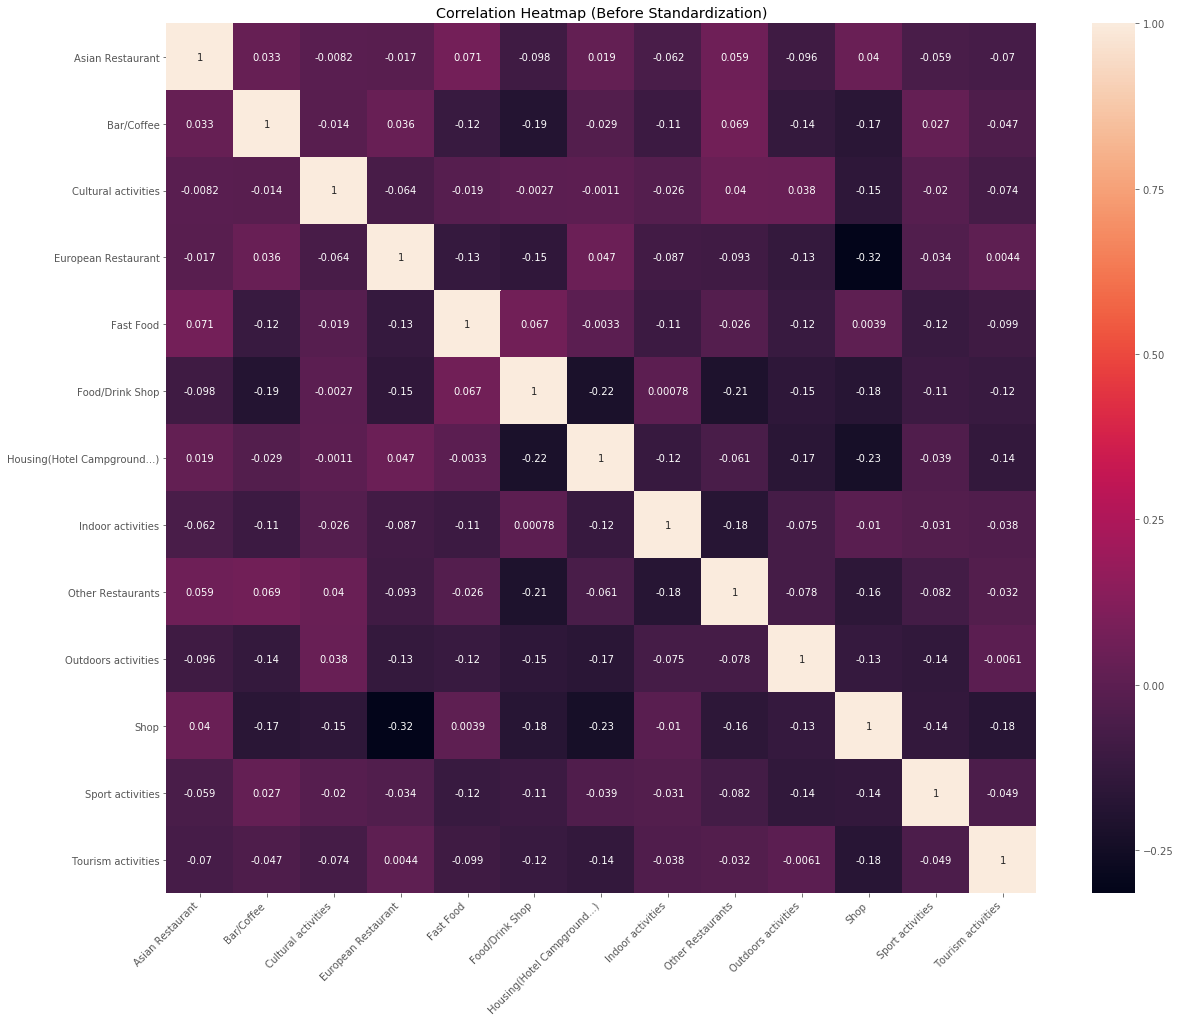

In [34]:
data_histo=df2.drop(['lng','distance','population','name_std','countryName','lat'],axis=1).set_index('name')
data_histo.corr()

corr_min=min(list(data_histo.corr().min(axis=0)))
corr_max=max(list(data_histo.corr().max(axis=0)))
plt.figure(figsize=(20,16))

ax= sns.heatmap(data_histo.corr(), annot=True, square=True, vmin=corr_min, vmax=corr_max)

ax.set_ylim(13,0)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.title('Correlation Heatmap (Before Standardization)')
plt.show()


As the standardization is arbitray, it can create correlation between inputs. So we will use PCA to Mapreduce our feature space. But PCA is sensitive to data. Better with data without outliers and in the same scale.
Check our data.

It exist a multiple type of scaling methods. Most known is Z-scaling:
$$ x_{i}' = \dfrac{x_i - \bar{x}}{\sigma_{x}} $$

But this method is not robust and sensive to outliers. Try others, MAD scaling is a better approch:

$$ MAD\,scalling: x_{i}' = \dfrac{x_i - median(x)}{MAD(x)} $$

with $$ MAD(x) = Median(|x_i - median(x)|) $$

We also try Mean/AAD scaling (Average Absolute deviation)

$$  AAD\,scalling: x_{i}' = \dfrac{x_i - \bar{x}}{AAD(x)} $$

with $$ AAD(x) = \dfrac{1}{n} \sum_{i=1}^{n}(|x_i - \bar{x}|) $$


The two last method ar emore robust than first.


/!\ In pandas library, there is a MAD method available. But it is a language abuse (Mean = Average). The MAD method implemented is the AAD. Proof below:



In [35]:
from numpy.random import seed, rand
seed(1)
# generate some random numbers
x_ = pd.DataFrame(rand(20))

#MAD method of pandas
print('Pandas MAD: ', x_.mad())

#AAD method
print('AAD: ', np.mean(np.absolute(x_ - x_.mean())))

Pandas MAD:  0    0.202912
dtype: float64
AAD:  0    0.202912
dtype: float64


And then as it is possible to have a median to 0 in MAD method, to overpass the behvaior of python to writte as inf (when you have 1/0)  or NA (when you have 0/1 or 0/0) we replace by the real meaning**

** when you have a cake and divide by nothing, you always have your cake, not in infinite of cake, And when you have nothing and divide by nothing or something, you always have nothing)

In [36]:
x=pd.DataFrame()
x['before division']=[1,0]
x['after division by 0'] = [1,0]
x['after division by 0']=x['after division by 0']/0
x

,before division,after division by 0
0,1,inf
1,0,NaN


As we want to use the best scaling method, based on the result of our methodology, we use a function wich:

- for a range of number of feature
    - compute PCA
    - for a range of k cluster
        - fit kmeans
        - compute silhouette and davies bouldin index
- plot a box plot of results

Remarks: We don't use pipeline of scikit learn is it more time consumming.

In [37]:
#Try some set of Weight and Scale for PCA input and Kmeans
def which_config(dataset, title):
    #--> Uncomment print statement to see the progress
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    import sklearn.metrics as metrics

    np.seterr(divide='ignore')
    
    results_silhouette, results_davies, names = list(), list(), list()
    max_feature=5
    max_nb_cluster=8
    for i in range(1,max_feature+1):
        #print('-------------------------------')
        #print(i,' features for PCA')
        X = dataset 
        X2 = PCA(n_components=i).fit_transform(X)

        for k in range(2,max_nb_cluster+1):
            #print('**********')
            #print('k=',k)
            cl = KMeans(init='k-means++',n_clusters=k,random_state=0).fit_predict(X2)
            if len(np.unique(cl)) != 1:
                silhouette=metrics.silhouette_score(X2, cl, metric='euclidean')
                davies=metrics.davies_bouldin_score(X2, cl)
            else:
                silhouette=-20
                davies=20
            name_=str(i)+':'+str(k)
            names.append(name_)
            results_silhouette.append(silhouette)
            results_davies.append(davies)
            #print('silhouette score for',i,':',k,':',silhouette)
            #print('davies score for',i,':',k,':',davies

    r_df = pd.DataFrame()
    r_df['ACP n_feature']=[i.split(':', 1)[0] for i in names]
    r_df['ACP n_feature']=r_df['ACP n_feature'].astype(int)
    r_df['kmeans k cluster']=[i.split(':', 1)[1] for i in names]
    r_df['kmeans k cluster']=r_df['kmeans k cluster'].astype(int)
    r_df['silhouette score']=results_silhouette
    r_df['davies score']=results_davies
 
    x_data=pd.melt(r_df.drop(['kmeans k cluster','ACP n_feature'],axis=1)) #transpose the dataset
    #list of number of cluster (repeat for each metrics)
    k =  [ele  for i in range(2) for ele in np.arange(1,max_feature+1,1) for ele in np.arange(2,max_nb_cluster+1,1) ]
    x_data['k']=k
    f = [i   for ele in range(2)  for i in np.arange(1,max_feature+1,1) for ele in np.arange(2,max_nb_cluster+1,1)]
    x_data['f']=f
    x_data.sort_values(by=['k','f'], inplace=True)
    davies_df = x_data[x_data['variable']=='davies score']
    silhouette_df=x_data[x_data['variable']=='silhouette score']

    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})

    # plot of Davies Bouldin
    sns.boxplot(x='f', y='value',data=davies_df,palette='bright', ax=ax1)
    ax1.set(xlabel='PCA features', ylabel='Metric Value')
    ax1.title.set_text('Davies Boulding Score')

    #Plot of silhouette score
    sns.boxplot(x='f', y='value',data=silhouette_df,palette='pastel', ax=ax2)
    ax2.set(xlabel='PCA features', ylabel='')
    ax2.title.set_text('Silhouette Score')

    fig.tight_layout()
    fig.suptitle(title + ' \n - Range of metrics value for different values of k \n in clustering and different N feature space in PCA',y=1.1,fontsize='xx-large')
    plt.show()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


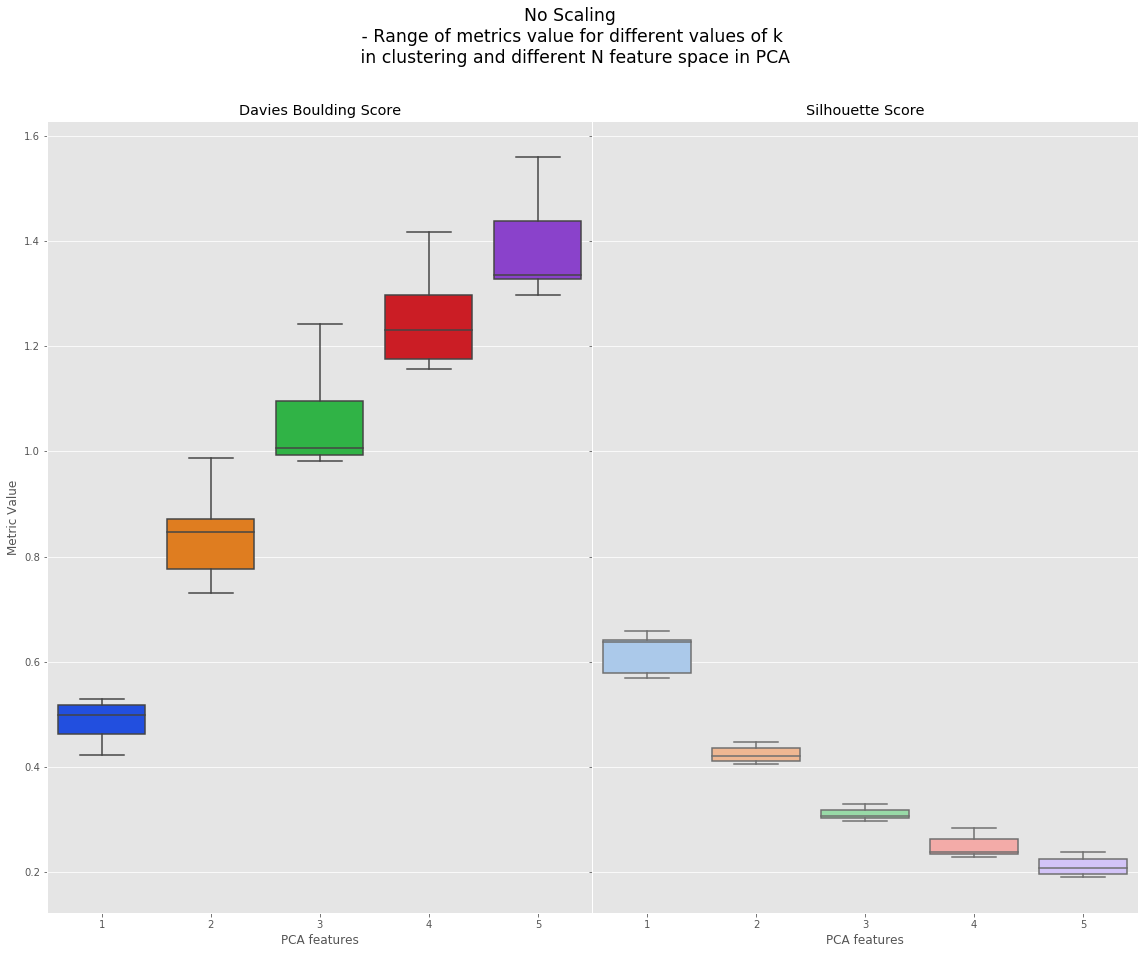

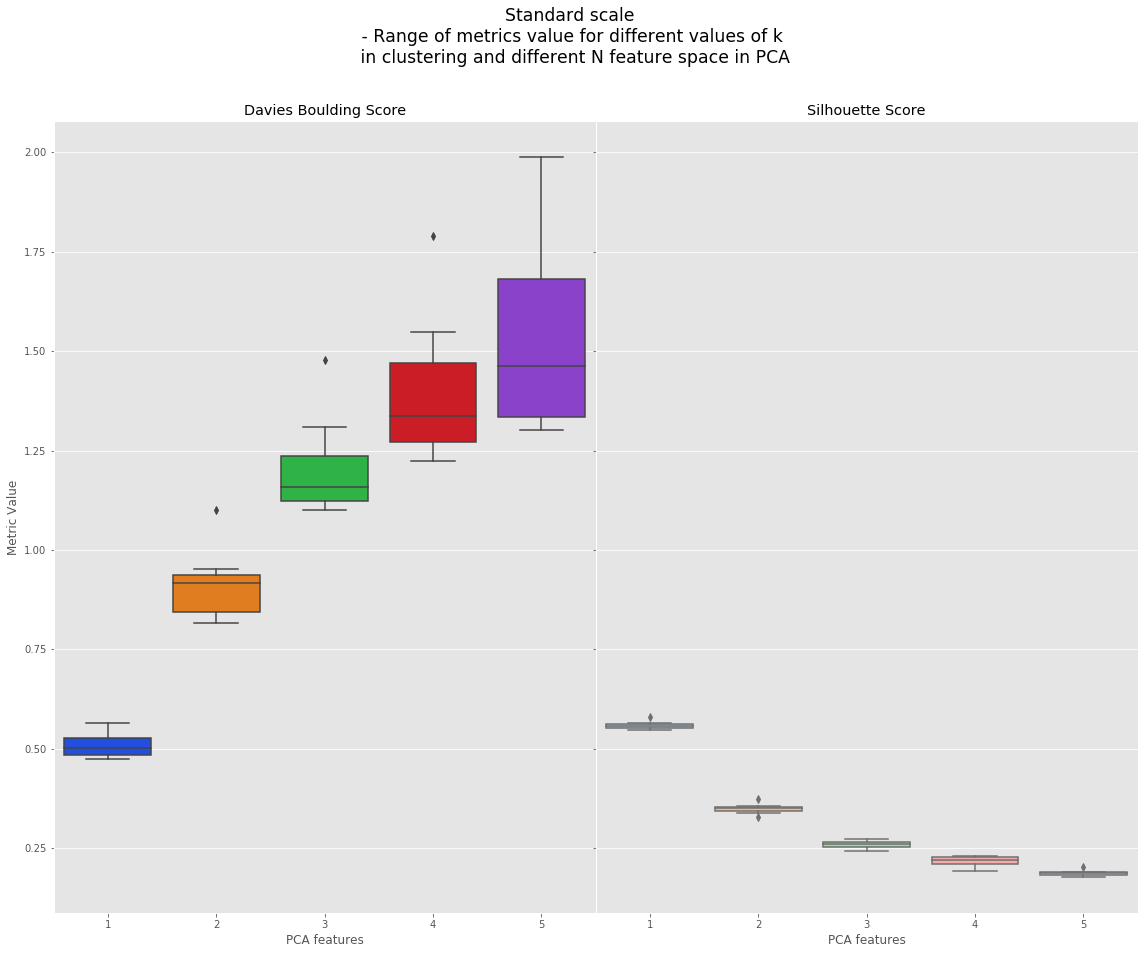

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


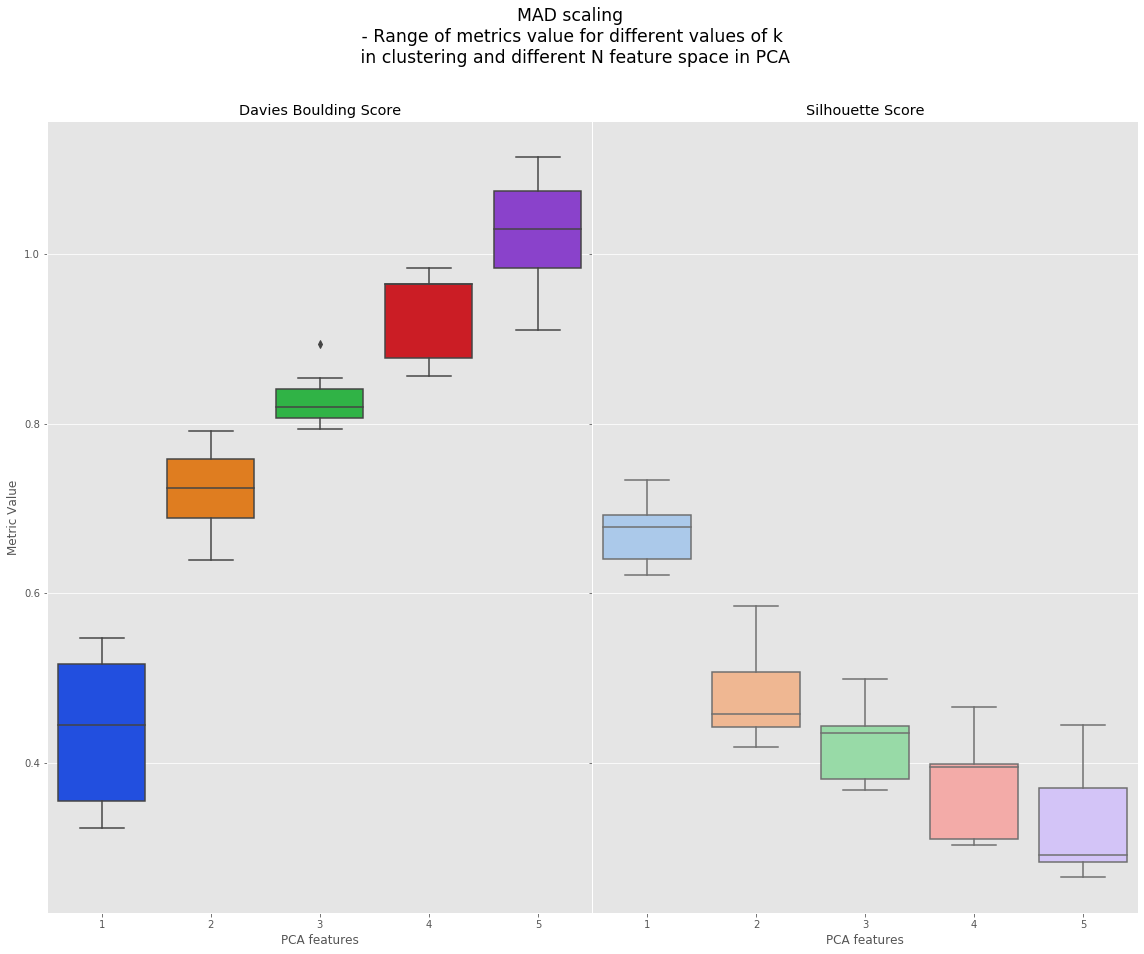

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


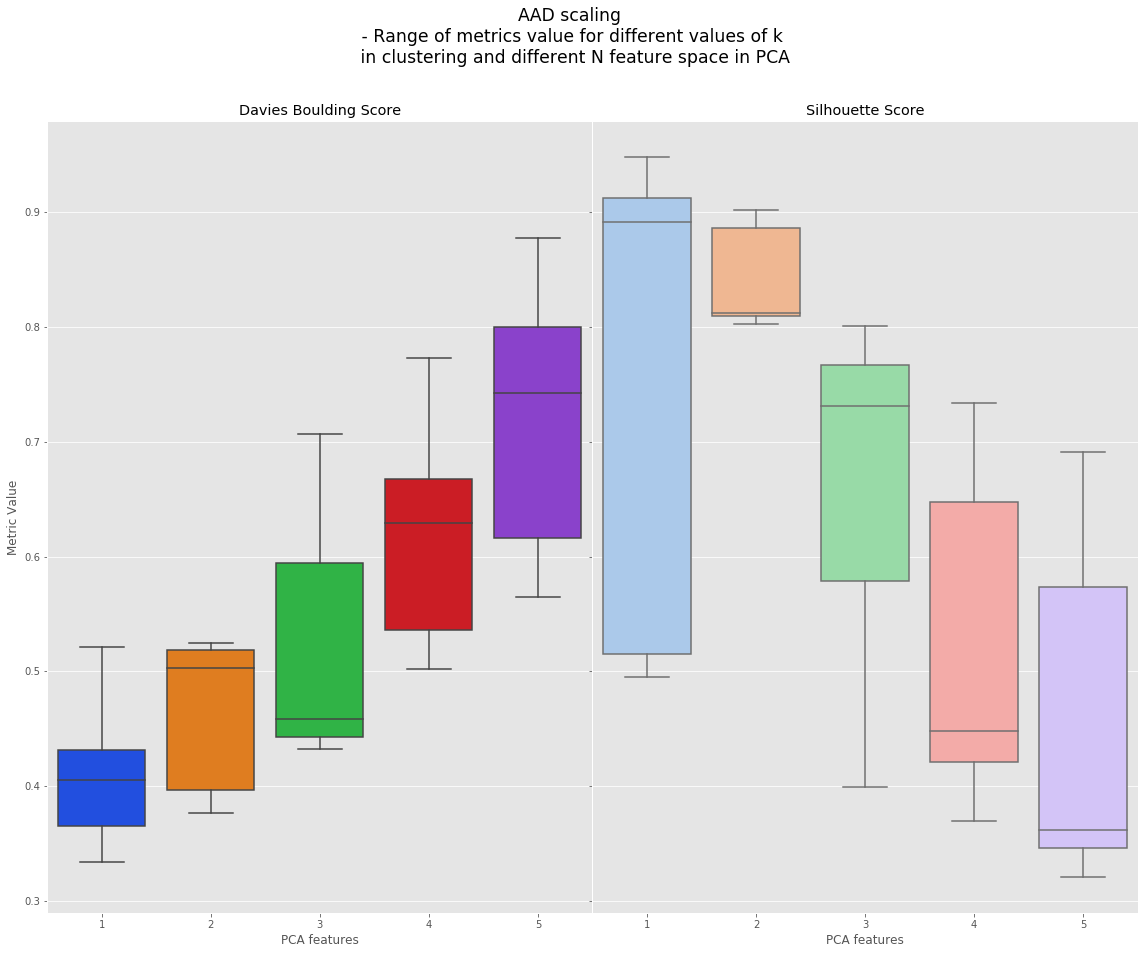

In [38]:
#Base Dataset
df_b=df2.drop(['lng','distance','population','lat','name_std','countryName'],axis=1).set_index('name')

#------------------------------
#no Weight
which_config(dataset=df_b, title='No Scaling')

#------------------------------
#Standard Scale
df_sc = (df_b - df_b.mean())/df_b.std()
which_config(dataset=df_sc, title='Standard scale')

#------------------------------
# MAD Scaling
mad=[]
df_mad=pd.DataFrame()
for j in df_b.columns:
    s = df_b[j] 
    med = np.median(s)
    x = np.absolute(s - med)    
    mad_=np.median(x)
    mad.append(mad_)
    df_mad[j]= x / mad_
df_mad.replace(np.inf, 1, inplace=True)
df_mad.fillna(0,inplace=True)

which_config(dataset=df_mad, title='MAD scaling')

#------------------------------
# AAD scaling
df_aad = (df_b - df_b.mean()) / df_b.mad()
which_config(dataset=df_aad, title='AAD scaling')



So AAD scaling seems it the best scaling method. We keep it.

In [39]:
df_aad.describe().T


,count,mean,std,min,25%,50%,75%,max
Asian Restaurant,320.0,-2.220446e-17,2.586409,-0.535117,-0.535117,-0.535117,-0.535117,22.570363
Bar/Coffee,320.0,3.219647e-16,1.351855,-0.680052,-0.680052,-0.680052,-0.024956,5.998114
Cultural activities,320.0,1.110223e-17,2.259549,-0.551697,-0.551697,-0.551697,-0.551697,15.762459
European Restaurant,320.0,1.665335e-16,1.204623,-0.875152,-0.875152,-0.875152,0.878509,5.701077
Fast Food,320.0,2.775558e-16,1.440185,-0.638080,-0.638080,-0.638080,-0.638080,6.206804
Food/Drink Shop,320.0,-6.161738e-16,1.253839,-1.130828,-1.130828,-0.227397,0.597475,5.782385
Housing(Hotel Campground...),320.0,3.733125e-16,1.225581,-1.035548,-1.035548,-0.288328,0.945919,7.183873
Indoor activities,320.0,1.110223e-16,1.680932,-0.636085,-0.636085,-0.636085,-0.636085,8.244677
Other Restaurants,320.0,5.037637e-16,1.220903,-0.920845,-0.920845,-0.920845,0.709948,5.602329
Outdoors activities,320.0,3.608225e-16,1.326596,-0.779864,-0.779864,-0.779864,0.398123,7.900042


Checkt the correlation between before and after AAD scaling

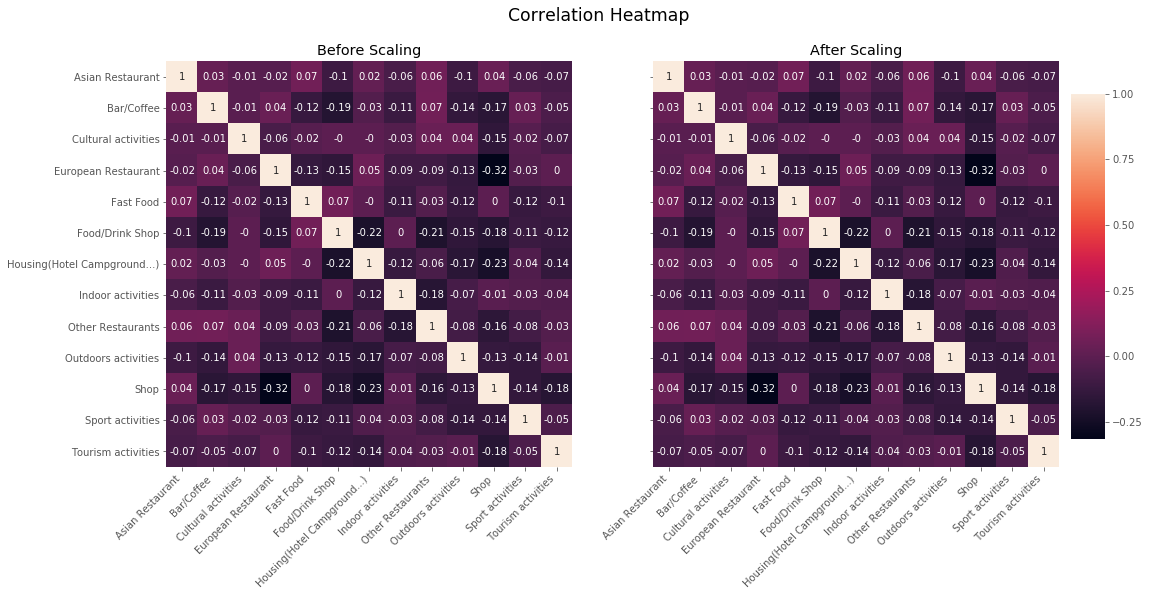

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0.2})
cbar_ax = fig.add_axes([.91, .3, .03, .4])

corr_min=min(list(data_histo.corr().min(axis=0)))
corr_max=max(list(data_histo.corr().max(axis=0)))
sns.heatmap(round(data_histo.corr(),2), annot=True, square=True, vmin=corr_min, vmax=corr_max, ax=ax1, cbar=0, cbar_ax=cbar_ax)
#ax1.set_ylim(14,0)
ax1.title.set_text('Before Scaling')
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

corr_min=min(list(df_aad.corr().min(axis=0)))
corr_max=max(list(df_aad.corr().max(axis=0)))
sns.heatmap(round(df_aad.corr(),2), annot=True, square=True, vmin=corr_min, vmax=corr_max, ax=ax2, cbar=1,cbar_ax=cbar_ax)
ax2.set_ylim(13,0)
ax2.title.set_text('After Scaling')
ax2.set_xticklabels(
    ax2.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');


fig.suptitle('Correlation Heatmap',y=0.8,fontsize='xx-large')
plt.show()



So good news, this scaling method has kept the shape of our data.

___

# Step 3 : Principal Component Analysis and Kmeans clustering

### Grid Search : Which f and which k

First we want to find the optimal number of feature in combination of the number of clustering. 
For this we will performed a small grid search and use silhouette score and davies bouldin score to find the bestvalue of 'f' (the number of feature for PCA) and 'k' (the number of cluster in kmeans)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


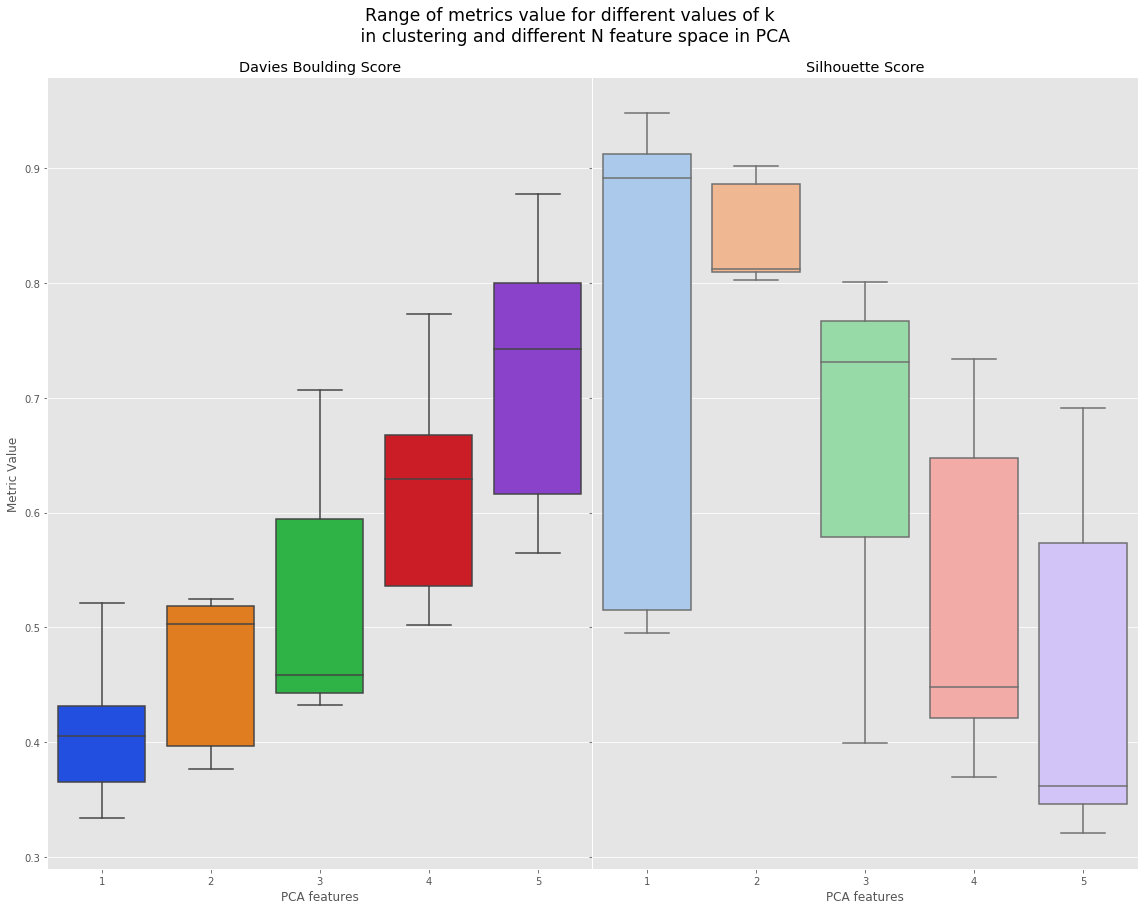

In [41]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sklearn.metrics as metrics

np.seterr(divide='ignore')

results_silhouette, results_davies, names = list(), list(), list()
max_feature=5
max_nb_cluster=8
for i in range(1,max_feature+1):
    X = df_aad 
    X2 = PCA(n_components=i).fit_transform(X)
    for k in range(2,max_nb_cluster+1):
        cl = KMeans(init='k-means++',n_clusters=k,random_state=0).fit_predict(X2)
        silhouette=metrics.silhouette_score(X2, cl, metric='euclidean')
        davies=metrics.davies_bouldin_score(X2, cl)
        name_=str(i)+':'+str(k)
        names.append(name_)
        results_silhouette.append(silhouette)
        results_davies.append(davies)

r_df = pd.DataFrame()
r_df['ACP n_feature']=[i.split(':', 1)[0] for i in names]
r_df['ACP n_feature']=r_df['ACP n_feature'].astype(int)
r_df['kmeans k cluster']=[i.split(':', 1)[1] for i in names]
r_df['kmeans k cluster']=r_df['kmeans k cluster'].astype(int)
r_df['silhouette score']=results_silhouette
r_df['davies score']=results_davies

x_data=pd.melt(r_df.drop(['kmeans k cluster','ACP n_feature'],axis=1)) #transpose the dataset
#list of number of cluster (repeat for each metrics)
k =  [ele  for i in range(2) for ele in np.arange(1,max_feature+1,1) for ele in np.arange(2,max_nb_cluster+1,1) ]
x_data['k']=k
f = [i   for ele in range(2)  for i in np.arange(1,max_feature+1,1) for ele in np.arange(2,max_nb_cluster+1,1)]
x_data['f']=f
x_data.sort_values(by=['k','f'], inplace=True)
davies_df = x_data[x_data['variable']=='davies score']
silhouette_df=x_data[x_data['variable']=='silhouette score']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})

# plot of Davies Bouldin
sns.boxplot(x='f', y='value',data=davies_df,palette='bright', ax=ax1)
ax1.set(xlabel='PCA features', ylabel='Metric Value')
ax1.title.set_text('Davies Boulding Score')

#Plot of silhouette score
sns.boxplot(x='f', y='value',data=silhouette_df,palette='pastel', ax=ax2)
ax2.set(xlabel='PCA features', ylabel='')
ax2.title.set_text('Silhouette Score')

fig.tight_layout()
fig.suptitle('Range of metrics value for different values of k \n in clustering and different N feature space in PCA',y=1.05,fontsize='xx-large')
plt.show()

So Two feature in PCA seems not bad (not best but good)

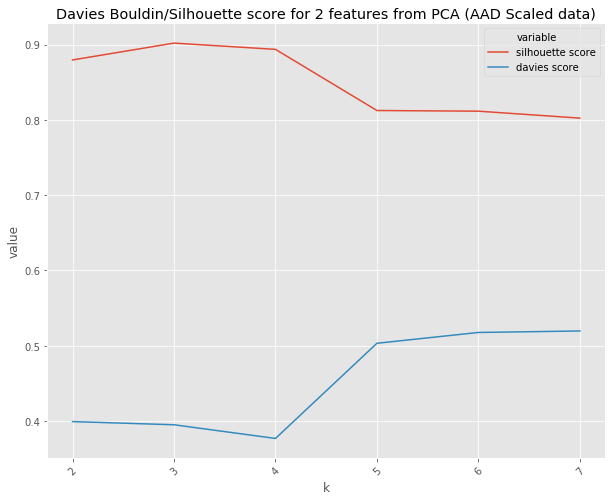

In [42]:
#We keep True Robust Median/ MAD scale

# Mad Scale
np.seterr(divide='ignore')

results_silhouette, results_davies, names = list(), list(), list()
X2 = PCA(n_components=2).fit_transform(df_aad)

n_cluster_max=8
for k in range(2,n_cluster_max):
    #print('**********')
    #print('k=',k)
    cl = KMeans(init='k-means++',n_clusters=k,random_state=0).fit_predict(X2)
    silhouette=metrics.silhouette_score(X2, cl, metric='euclidean')
    davies=metrics.davies_bouldin_score(X2, cl)
    name_=str(k)
    names.append(name_)
    results_silhouette.append(silhouette)
    results_davies.append(davies)
    #print('silhouette score for',i,':',k,':',silhouette)
    #print('davies score for',i,':',k,':',davies
r_df = pd.DataFrame()
r_df['kmeans k cluster']=[i[0] for i in names]
r_df['kmeans k cluster']=r_df['kmeans k cluster'].astype(int)
r_df['silhouette score']=results_silhouette
r_df['davies score']=results_davies
r_df.head(8)

#r_df2=r_df[r_df['ACP n_feature']==2]
x_data=pd.melt(r_df.drop(['kmeans k cluster'],axis=1)) #transpose the dataset
#calc how many metric
#list of number of cluster (repeat for each metrics)
k =  [ele  for i in range(2)  for ele in np.arange(2,n_cluster_max,1) ]
k
x_data['k']=k
x_data.sort_values(by=['k'], inplace=True)
davies_df = x_data[x_data['variable']=='davies score']
silhouette_df=x_data[x_data['variable']=='silhouette score']
plt.figure(figsize=(10,8))
sns.lineplot(x='k', y='value', hue='variable',data=x_data)
plt.title('Davies Bouldin/Silhouette score for 2 features from PCA (AAD Scaled data)')
plt.xticks(rotation=45)
plt.show()



So 3 or 4 clusters is a good value of k

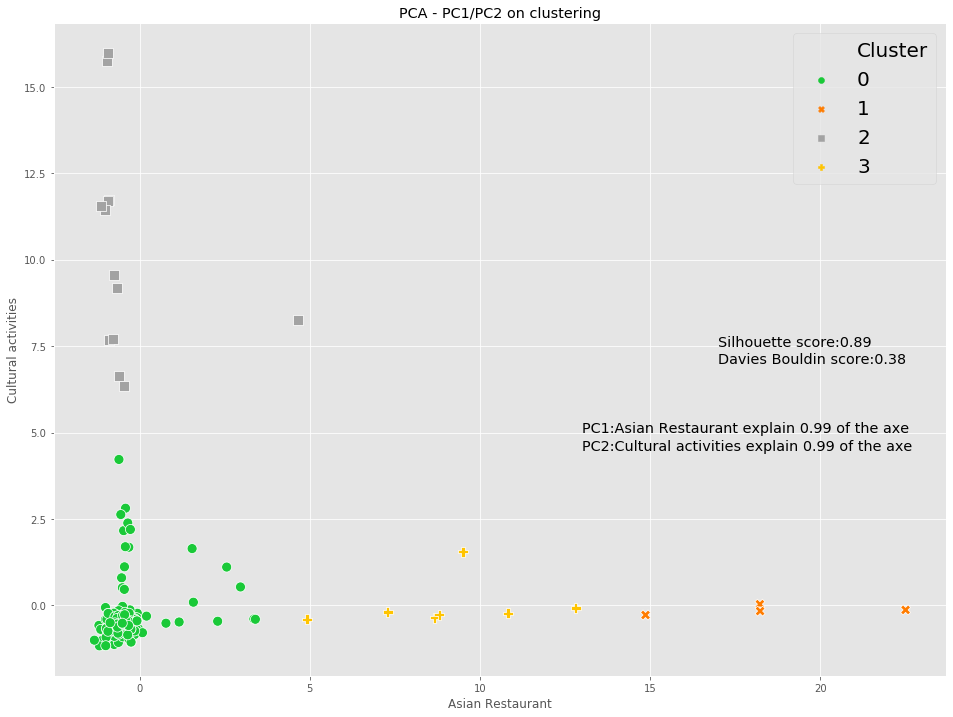

In [43]:
try:
    df_aad.drop('Cluster',axis=1, inplace=True)
except :
    pass
X2 = PCA(n_components=2).fit_transform(df_aad)

#Keep the composition of PCA to interpret it
compo = PCA(n_components=2)
compo.fit_transform(df_aad)
compo=pd.DataFrame(compo.components_,columns=df_aad.columns,index = ['PC-1','PC-2'])

cl = KMeans(init='k-means++',n_clusters=4,random_state=0,max_iter=500).fit_predict(X2)
silhouette=metrics.silhouette_score(X2, cl, metric='euclidean')
davies=metrics.davies_bouldin_score(X2, cl)

X2 = pd.DataFrame(X2)
try:
    df_aad.insert(0,'Cluster',cl)
except :
    df_aad.drop('Cluster',axis=1, inplace=True)
    df_aad.insert(0,'Cluster',cl)
    
try:
    df2.insert(0,'Cluster',cl)   
except ValueError: 
    df2.drop('Cluster',axis=1, inplace=True) 
    df2.insert(0,'Cluster',cl)
    
try:
    X2.insert(0,'Cluster',cl)   
except ValueError: 
    X2.drop('Cluster',axis=1, inplace=True) 
    X2.insert(0,'Cluster',cl)
X2.insert(0,'name',df_aad.index)    
X2.reset_index(inplace=True)
X2.sort_values('Cluster',inplace=True)

explain=list()
for i,c in enumerate((compo.T).columns):
    x=compo.T[compo.T[c] == compo.T[c].max()]
    xx=dict(x[c])
    explain.append(xx)


palette = sns.color_palette('bright')
from random import choice
palette = sns.color_palette('bright')
sequence = [i for i in range(len(palette))]
color=list()
for _ in range(len(X2.Cluster.unique())):
    selection = palette[choice(sequence)]
    color.append(selection)

fig, ax = plt.subplots(figsize=(16,12))
sns.scatterplot(x=0,y=1, data=X2, hue='Cluster', style="Cluster", s=100 , palette=color, ax=ax)
plt.legend(prop={'size': 20})

plt.title('PCA - PC1/PC2 on clustering')
ax.set_xlabel(list(explain[0].keys())[0])
ax.set_ylabel(list(explain[1].keys())[0])
plt.annotate('Silhouette score:' + str(round(silhouette,2)),xy=(17,7.5), size='x-large')
plt.annotate('Davies Bouldin score:' + str(round(davies,2)),xy=(17,7), size='x-large')

plt.annotate('PC1:' + list(explain[0].keys())[0] + ' explain ' + str(round(list(explain[0].values())[0],2)) + ' of the axe', xy=(13,5), size='x-large')
plt.annotate('PC2:' + list(explain[1].keys())[0] + ' explain ' + str(round(list(explain[1].values())[0],2)) + ' of the axe', xy=(13,4.5), size='x-large')
plt.show()




Now if we plot our clustering

In [44]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude,longitude], zoom_start=9)

folium.Circle(
    [latitude,longitude],
    radius=100000,
    popup="Maximum authorized perimeter (100km)",
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.5,).add_to(map_clusters)  


label = folium.Popup(location, parse_html=True)

folium.CircleMarker(
    [latitude,longitude],
    radius=10,
    popup=label,
    color='black',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(map_clusters) 

nb_cluster=len(df2['Cluster'].unique())
x = np.arange(nb_cluster)
ys = [i + x + (i*x)**2 for i in range(nb_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

 #   rainbow=color_list #list hex de color example: ['#66ccff','#00ff00','#ccff33']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df2['lat'], df2['lng'], df2['name_std'], df2['Cluster'] ):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [45]:
#Assess Cluster

In [46]:
#overall mean for each variable

def assess_clustering(x, var_cluster, print_='N'):
    a=x.drop(var_cluster,axis=1)
    tmp=pd.DataFrame()
    m=a.mean()
    tmp['Mean']=m
    TSS=a.shape[0]*a.var(ddof=0)
    tmp['TSS']=TSS
    
    gb = x.groupby(var_cluster)
    nk = gb.size()
    
    mk=gb.mean()
    
    EMK = (mk-m)**2
    EM = EMK.multiply(nk,axis=0)
    
    BSS=np.sum(EM,axis=0)
    tmp['BSS'] = BSS
    
    R2=BSS/TSS
    tmp['R2'] = R2
  
    if print_=='Y':
        print('-----------------\n TSS: \n', TSS)
        print('-----------------\n nk: \n',nk)
        print('-----------------\n mk : \n',mk)
        print('-----------------\n Between: \n ',BSS)  
        print('-----------------\n BSS/TSS (R2) : \n',R2)
    return tmp

cluster_asses = assess_clustering(x=df_aad, var_cluster='Cluster')
round(cluster_asses,2)

,Mean,TSS,BSS,R2
Asian Restaurant,0.0,2133.95,1965.63,0.92
Bar/Coffee,0.0,582.98,0.37,0.00
Cultural activities,0.0,1628.67,1416.59,0.87
European Restaurant,0.0,462.91,3.07,0.01
Fast Food,0.0,661.65,8.39,0.01
Food/Drink Shop,-0.0,501.50,3.35,0.01
Housing(Hotel Campground...),0.0,479.15,1.64,0.00
Indoor activities,0.0,901.35,4.38,0.00
Other Restaurants,0.0,475.50,4.75,0.01
Outdoors activities,0.0,561.39,6.95,0.01


## Step 4 : Building Custom Score


|Variable        |modalities                  |Coefficient| |Value ||Score |
|--------|----------|-----------|---|-----|---|-----|
| Venue Category |Bar/Coffee                         |__b0__| | -- |  | -- |
|                |Fast Food                      |__b1__| | -- |  | -- |
|                |Commodities                 |__b2__| | -- |  | -- |
|                |Cultural activities         |__b3__| | -- |  | -- |
|                |Food/Drink Shop             |__b4__| | -- |  | -- |
|                |Housing(Hotel Campground...)|__b5__| | -- |  | -- |
|                |Indoor activities           |__b6__| | -- |  | -- |
|                |Outdoors activities         |__b7__| | -- |  | -- |
|                |Other Restaurant                  |__b8__| | -- |  | -- |
|                |Shop                        |__b9__| | -- |  | -- |
|                |Sport activities            |__b10__| | -- |  | -- |
|                |Tourism activities          |__b11__| | -- |  | -- |
|                |Asian Restaurant                            |__b12__| | -- |  | -- |
|                |European Restaurant                         |__b13__| | -- |  | -- |


## 4.1 : Input the weight of each type of category

In [47]:
df_aad.columns

Index(['Cluster', 'Asian Restaurant', 'Bar/Coffee', 'Cultural activities',
       'European Restaurant', 'Fast Food', 'Food/Drink Shop',
       'Housing(Hotel Campground...)', 'Indoor activities',
       'Other Restaurants', 'Outdoors activities', 'Shop', 'Sport activities',
       'Tourism activities'],
      dtype='object')

In [48]:
#To run manually
b0=-3 #Asian Restaurant
b1=5 #Bar/Coffee
b2=4 # Cultural activities
b3=3 # European Restaurant
b4=-5 # FastFood
b5=2 #Food/Drink Shop
b6=2 #Housing (Hotel, Campground...)
b7=-1 #Indoor activities
b8=-2 # Other Restaurants
b9=4 #Outdoor activities
b10=2 # Shop
b11=3 #Sports Activities
b12=4 # Tourism Activities
score_scale=100 #Scale of the final score


b=list([{'Asian Restaurant':b0 }, 
        {'Bar/Coffee':b1 }, 
        {'Cultural activities':b2 }, 
        {'European Restaurant':b3 }, 
        {'Fast Food':b4 }, 
        {'Food/Drink Shop':b5 }, 
        {'Housing(Hotel Campground...)':b6 }, 
        {'Indoor activities':b7 }, 
        {'Other Restaurants':b8 }, 
        {'Outdoors activities':b9 }, 
        {'Shop':b10 }, 
        {'Sport activities':b11 }, 
        {'Tourism activities':b12},
        {'scale':score_scale}])
parm_value=list([b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12])
parm=list(['b0','b1','b2','b3','b4','b5','b6','b7','b8','b9','b10','b11','b12'])


## 4.2 : Build the Score Grid

In [49]:
from grid import score_grid
modal=sorted(df_scheme['Venue Category std'].unique().tolist())
Grid = score_grid(modalities=modal, param_list=parm_value,scale=100)
Grid

,variable,modality,Parameter,Score
0,Venue Category,Asian Restaurant,b0,20.0
1,Venue Category,Bar/Coffee,b1,100.0
2,Venue Category,Cultural activities,b2,90.0
3,Venue Category,European Restaurant,b3,80.0
4,Venue Category,Fast Food,b4,0.0
5,Venue Category,Food/Drink Shop,b5,70.0
6,Venue Category,Housing(Hotel Campground...),b6,70.0
7,Venue Category,Indoor activities,b7,40.0
8,Venue Category,Other Restaurants,b8,30.0
9,Venue Category,Outdoors activities,b9,90.0


## 4.3 Compute the score of each city


In [50]:
fields= sorted(df_scheme['Venue Category std'].unique().tolist())
df2['City Score']= np.dot(np.array(df2[fields]),Grid['Score']).round(2)
df2[['Cluster','City Score']].groupby('Cluster').mean()

,City Score
Cluster,
0,69.336824
1,49.125000
2,73.323077
3,60.242857


In [51]:
df2.sort_values(['Cluster','City Score'], ascending=False,inplace=True)


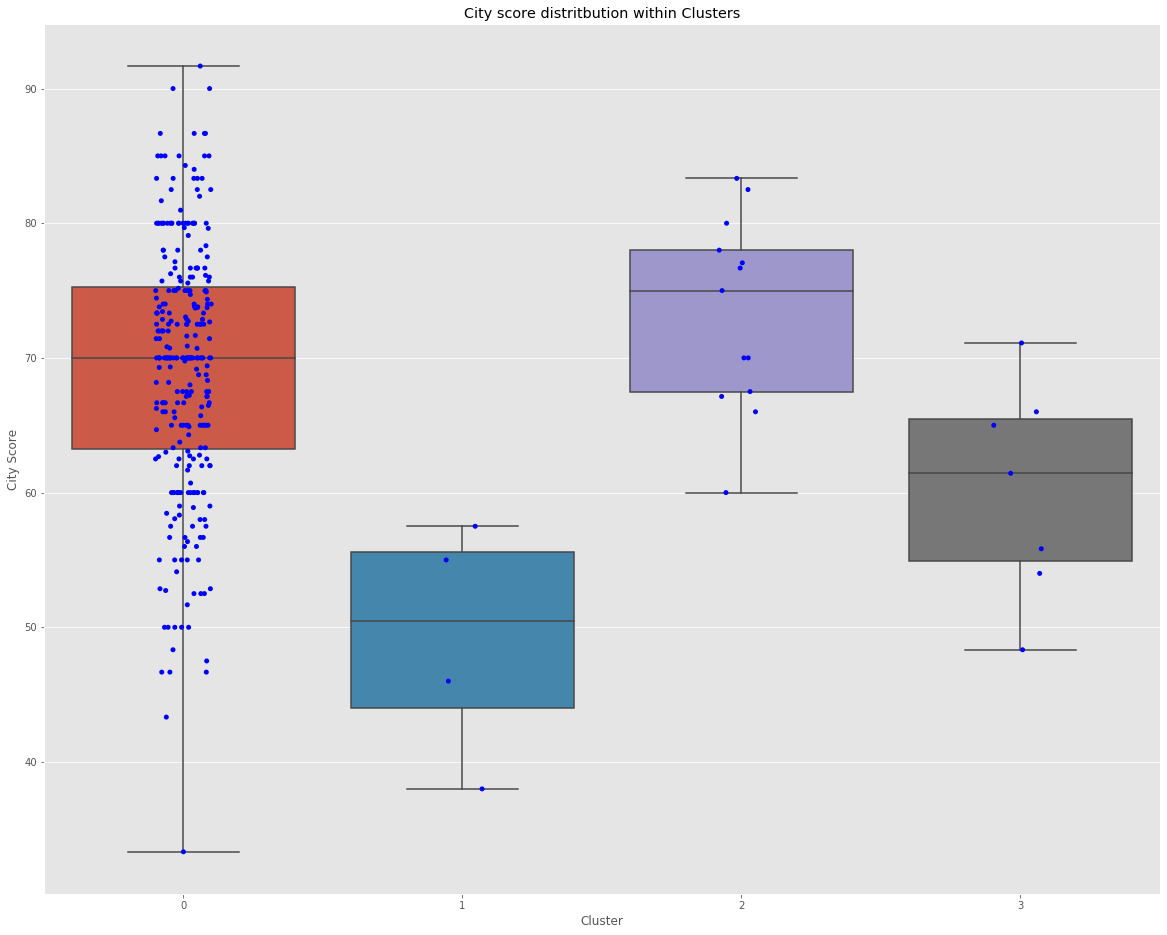

In [52]:
plt.figure(figsize=(20,16))
ax = sns.boxplot(y='City Score', x='Cluster', data=df2, whis=np.inf)
sns.stripplot(y='City Score', x='Cluster', data=df2, color='b')
plt.title('City score distritbution within Clusters')
plt.show()

As proof that the logit score also works, we compute the probabilities based on user's preferences.

We use the logistic function defined by:

$$ Pr(y)= \dfrac{1}{1 + e^{-X\beta}} $$

In [53]:
proba_y = 1/(1 + np.exp(- np.dot(np.array(df2[fields]), parm_value)))
df_proba=df2.copy()
df_proba['proba']=proba_y
df_proba[['name','City Score','proba']].sort_values('City Score', ascending=False).head(15)

,name,City Score,proba
17,Messery,91.67,0.984733
230,Coligny,90.00,0.982014
270,Novalaise,90.00,0.982014
25,Arthaz-Pont-Notre-Dame,86.67,0.975076
48,Ayse,86.67,0.975076
95,Bois-d'Amont,86.67,0.975076
163,Ugine,86.67,0.975076
41,Pers-Jussy,85.00,0.970688
148,Marcellaz-Albanais,85.00,0.970688
165,Bellignat,85.00,0.970688


In each cluster, we keep the five city with the highest score

In [54]:
def n_highest(cluster,n):
    tmp=df2[df2['Cluster']==cluster].sort_values('City Score', ascending=False)
    tmp=tmp.iloc[0:n]
    return tmp

In [66]:
top_n=5
h = pd.concat([n_highest(cluster=0,n=top_n) , n_highest(cluster=1,n=top_n), n_highest(cluster=2,n=top_n),n_highest(cluster=3,n=top_n)])
h[['Cluster','name','lat','lng','City Score']]

,Cluster,name,lat,lng,City Score
17,0,Messery,46.35036,6.29099,91.67
270,0,Novalaise,45.59480,5.77767,90.00
230,0,Coligny,46.38252,5.34554,90.00
25,0,Arthaz-Pont-Notre-Dame,46.15941,6.26598,86.67
48,0,Ayse,46.08135,6.44550,86.67
205,1,Doubs,46.92788,6.35104,57.50
227,1,Montmorot,46.67541,5.52283,55.00
122,1,Meythet,45.91836,6.09422,46.00
151,1,Arbent,46.29221,5.67890,38.00
93,2,Les Rousses,46.48412,6.06330,83.33


In [67]:
h.drop(['lat','lng','population','distance','name_std','countryName'],axis=1)

,Cluster,name,Asian Restaurant,Bar/Coffee,Cultural activities,European Restaurant,Fast Food,Food/Drink Shop,Housing(Hotel Campground...),Indoor activities,Other Restaurants,Outdoors activities,Shop,Sport activities,Tourism activities,City Score
17,0,Messery,0.000000,0.333333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.333333,91.67
270,0,Novalaise,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.333333,90.00
230,0,Coligny,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,90.00
25,0,Arthaz-Pont-Notre-Dame,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,86.67
48,0,Ayse,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,86.67
205,1,Doubs,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,57.50
227,1,Montmorot,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.500000,0.000000,0.000000,55.00
122,1,Meythet,0.200000,0.200000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,46.00
151,1,Arbent,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.000000,38.00
93,2,Les Rousses,0.000000,0.166667,0.166667,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,83.33


Plot of the city kept accroding to their score (5 by clusters)


In [68]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude,longitude], zoom_start=9)

folium.Circle(
    [latitude,longitude],
    radius=100000,
    popup="Maximum authorized perimeter (100km)",
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.5,).add_to(map_clusters)  


label = folium.Popup(location, parse_html=True)

folium.CircleMarker(
    [latitude,longitude],
    radius=10,
    popup=label,
    color='black',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(map_clusters) 

nb_cluster=len(h['Cluster'].unique())
x = np.arange(nb_cluster)
ys = [i + x + (i*x)**2 for i in range(nb_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

 #   rainbow=color_list #list hex de color example: ['#66ccff','#00ff00','#ccff33']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(h['lat'], h['lng'], h['name_std'], h['Cluster'] ):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [58]:
top_venues=Nearby_venues3[Nearby_venues3['City'].isin(h['name'])].sort_values(['City','Venue Category std'])
top_venues.shape

(73, 9)

We define a function to retrieve some information on venues locate in ranked city retained.

As it is possible that some venues have not a rating, we keep all information in a dataframe and clean it after.

In [59]:
def getrating(city,venue_name,venue_id):
    
    from pandas import json_normalize
    
    for c , v , i in zip(city,venue_name,venue_id):
       # print('city:', c)
       # print('venue:', v)
       # print('id', i)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
            
        #normalize the results
        results = requests.get(url).json()
        
        results2 = json_normalize(results)
        results2['city']=c
        
        try:
            r_df = pd.concat([r_df,results2],ignore_index=True)
        except NameError:
            r_df=results2
        
    return r_df

In [60]:
# to came back
results = pd.read_csv('save_getrating.csv')
results


,Unnamed: 0,meta.code,meta.requestId,response.venue.id,response.venue.name,response.venue.location.address,response.venue.location.lat,response.venue.location.lng,response.venue.location.labeledLatLngs,response.venue.location.postalCode,response.venue.location.cc,response.venue.location.city,response.venue.location.state,response.venue.location.country,response.venue.location.formattedAddress,response.venue.canonicalUrl,response.venue.categories,response.venue.verified,response.venue.stats.tipCount,response.venue.price.tier,response.venue.price.message,response.venue.price.currency,response.venue.likes.count,response.venue.likes.groups,response.venue.dislike,response.venue.ok,response.venue.allowMenuUrlEdit,response.venue.beenHere.count,response.venue.beenHere.unconfirmedCount,response.venue.beenHere.marked,response.venue.beenHere.lastCheckinExpiredAt,response.venue.specials.count,response.venue.specials.items,response.venue.photos.count,response.venue.photos.groups,response.venue.reasons.count,response.venue.reasons.items,response.venue.hereNow.count,response.venue.hereNow.summary,response.venue.hereNow.groups,response.venue.createdAt,response.venue.tips.count,response.venue.tips.groups,response.venue.shortUrl,response.venue.timeZone,response.venue.listed.count,response.venue.listed.groups,response.venue.seasonalHours,response.venue.pageUpdates.count,response.venue.pageUpdates.items,response.venue.inbox.count,response.venue.inbox.items,response.venue.attributes.groups,city,response.venue.contact.phone,response.venue.contact.formattedPhone,response.venue.contact.twitter,response.venue.location.crossStreet,response.venue.url,response.venue.likes.summary,response.venue.storeId,response.venue.page.pageInfo.description,response.venue.page.pageInfo.links.count,response.venue.page.pageInfo.links.items,response.venue.page.user.id,response.venue.page.user.firstName,response.venue.page.user.photo.prefix,response.venue.page.user.photo.suffix,response.venue.page.user.type,response.venue.page.user.tips.count,response.venue.page.user.lists.groups,response.venue.page.user.bio,response.venue.hours.status,response.venue.hours.richStatus.entities,response.venue.hours.richStatus.text,response.venue.hours.isOpen,response.venue.hours.isLocalHoliday,response.venue.hours.dayData,response.venue.hours.timeframes,response.venue.defaultHours.status,response.venue.defaultHours.richStatus.entities,response.venue.defaultHours.richStatus.text,response.venue.defaultHours.isOpen,response.venue.defaultHours.isLocalHoliday,response.venue.defaultHours.dayData,response.venue.defaultHours.timeframes,response.venue.bestPhoto.id,response.venue.bestPhoto.createdAt,response.venue.bestPhoto.source.name,response.venue.bestPhoto.source.url,response.venue.bestPhoto.prefix,response.venue.bestPhoto.suffix,response.venue.bestPhoto.width,response.venue.bestPhoto.height,response.venue.bestPhoto.visibility,response.venue.colors.highlightColor.photoId,response.venue.colors.highlightColor.value,response.venue.colors.highlightTextColor.photoId,response.venue.colors.highlightTextColor.value,response.venue.colors.algoVersion,response.venue.rating,response.venue.ratingColor,response.venue.ratingSignals,response.venue.description,response.venue.contact.facebook,response.venue.contact.facebookUsername,response.venue.contact.facebookName,response.venue.venuePage.id,response.venue.page.user.venue.id,response.venue.page.user.photo.default,response.venue.venueRatingBlacklisted,response.venue.popular.isOpen,response.venue.popular.isLocalHoliday,response.venue.popular.timeframes,response.venue.menu.type,response.venue.menu.label,response.venue.menu.anchor,response.venue.menu.url,response.venue.menu.mobileUrl,response.venue.menu.externalUrl,meta.errorType,meta.errorDetail
0,0,200,5edac26add0f85001b92a47c,4d237c3d3c026ea814de834e,Au Dragon D'Or,14 Allée des Fleurs,46.285483,5.661101,"[{'label': 'display', 'lat': 46.28548293364019...",1100.0,FR,Arbent,Rhône-Alpes,France,"['14 Allée des Fleurs'

So a little problem, we have reach the Foursquare API limit ...
So we treat the line without NAN to finished our topics.

In [61]:
results.dropna(axis=0,how='any',subset=['response.venue.name'],inplace=True)
#unwanted columns from the response
unwanted=['meta.code','meta.requestId','response.venue.contact.phone','response.venue.location.labeledLatLngs','response.venue.likes.groups','response.venue.allowMenuUrlEdit',
          'response.venue.beenHere.marked','response.venue.beenHere.unconfirmedCount','response.venue.beenHere.marked','response.venue.beenHere.lastCheckinExpiredAt',
          'response.venue.specials.count','response.venue.photos.groups','response.venue.venuePage.id','response.venue.reasons.count','response.venue.reasons.items','response.venue.page.user.id',
          'response.venue.page.user.firstName','response.venue.page.user.photo.prefix','response.venue.page.user.photo.suffix','response.venue.page.user.type','response.venue.page.user.venue.id',
          'response.venue.page.user.tips.count','response.venue.page.user.lists.groups','response.venue.page.user.bio','response.venue.hereNow.count','response.venue.hereNow.summary',
          'response.venue.hereNow.groups','response.venue.createdAt','response.venue.timeZone','response.venue.listed.groups','response.venue.hours.richStatus.entities','response.venue.hours.richStatus.text',
          'response.venue.hours.isOpen','response.venue.hours.isLocalHoliday','response.venue.hours.dayData','response.venue.defaultHours.status','response.venue.defaultHours.richStatus.entities',
          'response.venue.defaultHours.richStatus.text','response.venue.defaultHours.isOpen','response.venue.defaultHours.isLocalHoliday','response.venue.defaultHours.dayData',
          'response.venue.defaultHours.timeframes','response.venue.pageUpdates.count','response.venue.pageUpdates.items','response.venue.inbox.count','response.venue.inbox.items',
          'response.venue.attributes.groups','response.venue.bestPhoto.createdAt','response.venue.bestPhoto.source.name','response.venue.bestPhoto.source.url','response.venue.bestPhoto.prefix',
          'response.venue.bestPhoto.suffix','response.venue.bestPhoto.width','response.venue.bestPhoto.height','response.venue.bestPhoto.visibility','city','response.venue.contact.twitter',
          'response.venue.contact.facebook','response.venue.contact.facebookUsername','response.venue.contact.facebookName','response.venue.page.pageInfo.description',
          'response.venue.page.pageInfo.links.count','response.venue.page.pageInfo.links.items','response.venue.ratingSignals','response.venue.colors.highlightColor.photoId','response.venue.colors.highlightColor.value',
          'response.venue.colors.highlightTextColor.photoId','response.venue.colors.highlightTextColor.value','response.venue.colors.algoVersion','response.venue.popular.isOpen','response.venue.popular.isLocalHoliday',
          'response.venue.popular.timeframes','response.venue.location.crossStreet','response.venue.venueRatingBlacklisted']

#column that we want to keep
keep=['Unnamed: 0', 'response.venue.id', 'response.venue.name',
       'response.venue.location.address', 'response.venue.location.lat',
       'response.venue.location.lng', 'response.venue.location.postalCode',
       'response.venue.location.cc', 'response.venue.location.city',
       'response.venue.location.state', 'response.venue.location.country',
       'response.venue.location.formattedAddress',
       'response.venue.canonicalUrl', 'response.venue.categories',
       'response.venue.verified', 'response.venue.stats.tipCount',
       'response.venue.price.tier', 'response.venue.price.message',
       'response.venue.price.currency', 'response.venue.likes.count',
       'response.venue.dislike', 'response.venue.ok',
       'response.venue.beenHere.count', 'response.venue.specials.items',
       'response.venue.photos.count', 'response.venue.tips.count',
       'response.venue.tips.groups', 'response.venue.shortUrl',
       'response.venue.listed.count', 'response.venue.seasonalHours',
       'response.venue.contact.formattedPhone', 'response.venue.url',
       'response.venue.likes.summary', 'response.venue.storeId',
       'response.venue.hours.status', 'response.venue.hours.timeframes',
       'response.venue.bestPhoto.id', 'response.venue.rating',
       'response.venue.ratingColor', 'response.venue.description',
       'response.venue.page.user.photo.default', 'response.venue.menu.type',
       'response.venue.menu.label']

results_2 = results[keep]
columns=pd.Series(results_2.columns).str.split('.',expand=True)

columns
r=list()
for i in columns.index:
    for j in range(len(columns.columns)-1,-1,-1):
        c = columns[j].iloc[i]
        if c != None:
            r.append(c)
            #print(r)
            break

results_2.columns=r

results_2['Price'] = results_2['tier'].fillna(0).astype(int) * results_2['currency']
results_2.drop(['tier','currency','message','ratingColor'],axis=1,inplace=True)

#standardize name for remove accent in the map
results_2['name'] =results_2['name'].apply(unidecode.unidecode)
results_2['address'] = results_2['address'].astype(str).apply(unidecode.unidecode)

#create the label for the map
d=[]
for i in results_2.index:
    d.append( str(results_2.iloc[i]['name']) + ' (rating:' + str(results_2.iloc[i]['rating']) + ') \n ' + str(results_2.iloc[i]['city']) + ', ' +str(results_2.iloc[i]['address']) + '\n <a href="' + str(results_2.iloc[i]['url']) + '"> Website </a>' )

results_2['label']=d

results_2.head(5)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,Unnamed: 0,id,name,address,lat,lng,postalCode,cc,city,state,country,formattedAddress,canonicalUrl,categories,verified,tipCount,count,dislike,ok,count,items,count,count,groups,shortUrl,count,seasonalHours,formattedPhone,url,summary,storeId,status,timeframes,id,rating,description,default,type,label,Price
0,0,4d237c3d3c026ea814de834e,Au Dragon D'Or,14 Allee des Fleurs,46.285483,5.661101,1100.0,FR,Arbent,Rhône-Alpes,France,"['14 Allée des Fleurs', '01100 Arbent', 'France']",https://foursquare.com/v/au-dragon-dor/4d237c3...,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",False,0.0,0.0,False,False,0.0,[],0.0,0.0,"[{'type': 'others', 'name': 'All tips', 'count...",http://4sq.com/g0ZpZr,0.0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Au Dragon D'Or (rating:nan) \n Arbent, 14 Alle...",€€
1,1,4d1f785e756e8cfa6f9f6354,Quick,Allee des fleurs,46.283624,5.660232,NaN,FR,Arbent,Rhône-Alpes,France,"['Allée des fleurs (Allée des fleurs)', 'Arben...",https://foursquare.com/v/quick/4d1f785e756e8cf...,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",True,0.0,3.0,False,False,0.0,[],3.0,0.0,"[{'type': 'others', 'name': 'All tips', 'count...",http://4sq.com/hbs4cf,1.0,[],+33 4 74 75 32 49,http://www.quick.fr,3 Likes,quickfrance_q228f_fr,Closed until 11:00 AM,"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",56acd13e498ede4776a70138,NaN,NaN,NaN,NaN,"Quick (rating:nan) \n Arbent, Allee des fleurs...",€
2,2,4ced2998840a9eb051a09f13,Buffalo Grill,1 rue Francois Rochaix,46.274696,5.660058,1100.0,FR,Arbent,Rhône-Alpes,France,"['1 rue François Rochaix', '01100 Arbent', 'Fr...",https://foursquare.com/v/buffalo-grill/4ced299...,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",True,0.0,4.0,False,False,0.0,[],5.0,0.0,"[{'type': 'others', 'name': 'All tips', 'count...",http://4sq.com/gy8af0,1.0,[],+33 4 74 81 86 49,http://www.buffalo-grill.fr,4 Likes,NaN,NaN,NaN,54762280498e481515036fff,6.0,Chaîne de restaurants spécialisés en grillades...,NaN,NaN,"Buffalo Grill (rating:6.0) \n Arbent, 1 rue Fr...",€€€€
3,3,4eaaa6e2b6347a596a1ec124,Decathlon Oyonnax,Rue Francois Rochaix,46.269923,5.652780,1100.0,FR,Oyonnax,Rhône-Alpes,France,"['Rue Francois Rochaix', '01100 Oyonnax', 'Fra...",https://foursquare.com/v/decathlon-oyonnax/4ea...,"[{'id': '4bf58dd8d48988d1f2941735', 'name': 'S...",False,0.0,2.0,False,False,0.0,[],2.0,0.0,"[{'type': 'others', 'name': 'All tips', 'count...",http://4sq.com/s1PEir,0.0,"[{'seasonalRange': 'May 26–June 1', 'timeframe...",+33 4 74 76 56 45,https://www.decathlon.fr/store-view/magasin-de...,2 Likes,NaN,Closed until 9:30 AM,"[{'days': 'Mon–Sat', 'includesToday': True, 'o...",577cbd05498e293819a2ee56,6.8,Bienvenue dans votre magasin de sport de Decat...,NaN,NaN,"Decathlon Oyonnax (rating:6.8) \n Oyonnax, Rue...",NaN
4,4,4cdd6dcea1bba35d5d41a0e5,Geant Casino,Rue du 19 Mars 1962,46.283380,5.663330,1100.0,FR,Arbent,Auvergne-Rhône-Alpes,France,"['Rue du 19 Mars 1962', '01100 Arbent', 'France']",https://foursquare.com/v/g%C3%A9ant-casino/4cd...,"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",True,0.0,4.0,False,False,0.0,[],3.0,0.0,"[{'type': 'others', 'name': 'All tips', 'count...",http://4sq.com/bmVYlT,0.0,[],+33 4 74 81 24 00,http://magasins.geantcasino.fr/magasin/oyonnax...,4 Likes,NaN,Closed until 8:00 AM,"[{'days': 'Mon–Sun', 'includesToday': True, 'o...",54146432498e3e8e3c05105b,NaN,Toute l'actualité de votre magasin hypermarché...,NaN,NaN,"Geant Casino (rating:nan) \n Arbent, Rue du 19...",NaN


In [62]:
results_2.fillna(-1).groupby('rating').count()['id']

,id,id
rating,,
-1.0,39,39
5.9,1,1
6.0,1,1
6.2,1,1
6.3,1,1
6.8,1,1
6.9,2,2
7.6,1,1
8.0,1,1


So we have 39 venues not rated yet

In [63]:
from folium import plugins
map_final = folium.Map(location = [latitude, longitude], zoom_start = 9)
folium.Circle(
    [latitude,longitude],
    radius=100000,
    popup="Maximum authorized perimeter (100km)",
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.5,).add_to(map_final)  


label = folium.Popup(location, parse_html=True)

folium.CircleMarker(
    [latitude,longitude],
    radius=10,
    popup=label,
    color='black',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(map_final) 


# instantiate a mark cluster object for the incidents in the dataframe
venues = plugins.MarkerCluster().add_to(map_final)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, city, label_ in zip(results_2['lat'], results_2['lng'],results_2['city'],results_2['label']):
    #label_= city + '\n' + label
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label_,
    ).add_to(venues)

# display map
map_final